In [2]:
!pip install prophet pandas scikit-learn matplotlib tqdm --quiet

# Predicción de Regalías con Prophet Multivariado
### Tesis de Maestría en Ciencia de Datos
Este notebook utiliza Facebook Prophet con regresores externos para predecir regalías mensuales por artista.
Se evalúan métricas por artista y se exportan resultados para Power BI.

In [3]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm.notebook import tqdm

file_id = '1h97krjdPVuKszy9NVcZiWNQuPUu3ICyc' #version con artist_id
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,A01,2022-08-01,9181.530,6157095,2725818,0,0.000000,0,0,0,9181.530000,0.0000,0,0,0,0.000000,0,8
1,A01,2022-09-01,11326.315,6267740,2724330,0,0.000000,0,2,40,10253.922500,78237.8298,-1488,110645,0,0.000000,0,9
2,A01,2022-10-01,8111.670,6387042,2721716,0,0.555556,0,1,27,9539.838333,115000.6565,-2614,119302,0,0.185185,0,10
3,A01,2022-11-01,8916.570,6460584,2718405,1,0.610169,0,3,118,9384.021250,133558.2623,-3311,73542,1,0.388575,0,11
4,A01,2022-12-01,12755.920,6562667,2713392,1,0.538462,0,1,39,10058.401000,159183.7579,-5013,102083,2,0.568062,0,12


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from itertools import product
from tqdm.notebook import tqdm

# ========= Config =========
INIT_TRAIN   = 24   # meses iniciales (Prophet necesita historia)
HORIZON      = 6    # meses a validar
STEP         = 6    # avanzamos de a 6
STANDARDIZE_REGS = False  # poné True si querés z-score de regresores

# Grilla (ajustable)
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1, 5, 10]
}

# Regresores exógenos (sin 'month')
REGS = [
    'instagram_followers', 'twitter_followers', 'track_release', 'sentiment',
    'seguidores_menciones', 'cant_posteos', 'cant_comentarios',
    'mean_royalties_6m', 'std_instagram_followers_6m',
    'growth_twitter_followers', 'growth_instagram_followers',
    'sum_track_releases_6m', 'mean_sentiment_3m',
    'sum_seguidores_menciones_3m'
]

def zscore_clip(df, cols, clip=4.0):
    out = df.copy()
    for c in cols:
        x = out[c].astype(float).fillna(0.0)
        mu = x.mean()
        sd = x.std(ddof=0)
        if sd == 0 or np.isnan(sd):
            out[c] = 0.0
        else:
            z = (x - mu) / sd
            out[c] = z.clip(-clip, clip)
    return out

# ========= Tuning =========
resultados = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("fecha").reset_index(drop=True)
    n = len(group)
    if n < INIT_TRAIN + HORIZON:
        continue

    base = pd.DataFrame({
        'ds': pd.to_datetime(group['fecha']).dt.to_period("M").dt.to_timestamp(),
        'y' : group['royalties'].astype(float)
    })
    for c in REGS:
        base[c] = group[c].astype(float)

    if STANDARDIZE_REGS:
        base = zscore_clip(base, REGS, clip=4.0)

    # Loop hiperparámetros
    for params in product(*param_grid.values()):
        p = dict(zip(param_grid.keys(), params))
        folds_metrics = []

        # Expanding window: 1..INIT_TRAIN → validate next HORIZON; luego extendemos
        train_end = INIT_TRAIN
        while train_end + HORIZON <= n:
            train = base.iloc[:train_end].copy()
            test  = base.iloc[train_end:train_end + HORIZON].copy()

            try:
                m = Prophet(
                    seasonality_mode=p['seasonality_mode'],
                    changepoint_prior_scale=p['changepoint_prior_scale'],
                    seasonality_prior_scale=p['seasonality_prior_scale'],
                    changepoint_range=0.85,
                    n_changepoints=10,
                    yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False
                )
                for reg in REGS:
                    m.add_regressor(reg)

                m.fit(train.set_index('ds').asfreq('MS').reset_index())
                fcst = m.predict(test.drop(columns=['y']))

                y_true = test['y'].values
                y_hat  = fcst['yhat'].values

                mse  = mean_squared_error(y_true, y_hat)
                mae  = mean_absolute_error(y_true, y_hat)
                rmse = np.sqrt(mse)
                denom = np.where(y_true == 0, np.nan, y_true)
                mape = np.nanmean(np.abs((y_true - y_hat)/denom))

                folds_metrics.append((mse, mae, rmse, mape))

            except Exception as e:
                print(f"⚠️ {artist_id} params {p} – fold hasta {train_end}: {e}")

            train_end += STEP

        if folds_metrics:
            mse_mean, mae_mean, rmse_mean, mape_mean = np.nanmean(folds_metrics, axis=0)
            resultados.append({
                'Artist_ID': artist_id,
                **p,
                'MSE': mse_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'MAPE': mape_mean
            })

df_prom = pd.DataFrame(resultados)
best_params_expanding = (
    df_prom.sort_values(['Artist_ID', 'MAPE'])
    .groupby('Artist_ID').first().reset_index()
)

best_params_expanding.to_csv("prophet_best_params_por_artista_expanding.csv", index=False)
#df_prom.to_csv("prophet_df_promedios_expanding.csv", index=False)
print("✅ Tuning Prophet con expanding-window finalizado.")


  0%|          | 0/15 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81037', 'data', 'file=/tmp/tmphgdoxfz4/46jkzd69.json', 'init=/tmp/tmphgdoxfz4/i4batry2.json', 'output', 'file=/tmp/tmphgdoxfz4/prophet_model7exk2f00/prophet_model-20251011015047.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphgdoxfz4/53gw8lts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphgdoxfz4/vexoy8jo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41966', 'data', 'file=/tmp/tmphgdoxfz4/53gw8lts

✅ Tuning Prophet con expanding-window finalizado.


In [ ]:
#df_promedios = best_params_prophet.groupby(
#    ["seasonality_mode", "changepoint_prior_scale", "seasonality_prior_scale"]
#)[["MSE", "MAE", "RMSE", "MAPE"]].mean().reset_index()
#df_promedios.to_csv('prophet_df_promedios.csv', index=False)
print(df_prom)

    Artist_ID seasonality_mode  changepoint_prior_scale  \
0         A01         additive                    0.005   
1         A01         additive                    0.005   
2         A01         additive                    0.005   
3         A01         additive                    0.010   
4         A01         additive                    0.010   
..        ...              ...                      ...   
355       A15   multiplicative                    0.050   
356       A15   multiplicative                    0.050   
357       A15   multiplicative                    0.100   
358       A15   multiplicative                    0.100   
359       A15   multiplicative                    0.100   

     seasonality_prior_scale           MSE           MAE          RMSE  \
0                          1  3.214016e+08  1.671952e+04  1.792768e+04   
1                          5  7.420572e+09  8.039677e+04  8.614274e+04   
2                         10  8.232025e+08  2.300373e+04  2.869151e+0

In [ ]:
# -------------------------
# Convertir resultados a DataFrame y mostrar
# -------------------------
df_resultados = pd.DataFrame(resultados)

print("Resultados crudos:")
print(df_resultados)

print("\nMejores combinaciones por MAPE:")
print(df_resultados.sort_values(by="MAPE").head(10))

print("\nPromedio de métricas por configuración de hiperparámetros:")
df_promedios = df_resultados.groupby(
    ["seasonality_mode", "changepoint_prior_scale", "seasonality_prior_scale"]
)[["MSE", "MAE", "RMSE", "MAPE"]].mean().reset_index()
print(df_promedios.sort_values(by="MAPE").head(10))


Resultados crudos:
    Artist_ID seasonality_mode  changepoint_prior_scale  \
0         A01         additive                    0.005   
1         A01         additive                    0.005   
2         A01         additive                    0.005   
3         A01         additive                    0.010   
4         A01         additive                    0.010   
..        ...              ...                      ...   
355       A15   multiplicative                    0.050   
356       A15   multiplicative                    0.050   
357       A15   multiplicative                    0.100   
358       A15   multiplicative                    0.100   
359       A15   multiplicative                    0.100   

     seasonality_prior_scale           MSE           MAE          RMSE  \
0                          1  3.214016e+08  1.671952e+04  1.792768e+04   
1                          5  7.420572e+09  8.039677e+04  8.614274e+04   
2                         10  8.232025e+08  2.3003

# Hiperparametros finales

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# ========= Config =========
INIT_TRAIN = 24
HORIZON    = 6
STEP       = 6
STANDARDIZE_REGS = False

REGS = [
    'instagram_followers', 'twitter_followers', 'track_release', 'sentiment',
    'seguidores_menciones', 'cant_posteos', 'cant_comentarios',
    'mean_royalties_6m', 'std_instagram_followers_6m',
    'growth_twitter_followers', 'growth_instagram_followers',
    'sum_track_releases_6m', 'mean_sentiment_3m',
    'sum_seguidores_menciones_3m'
]


# ========= Función auxiliar =========
def zscore_clip(df, cols, clip=4.0):
    out = df.copy()
    for c in cols:
        x = out[c].astype(float).fillna(0.0)
        mu = x.mean(); sd = x.std(ddof=0)
        out[c] = 0.0 if (sd == 0 or np.isnan(sd)) else ((x - mu)/sd).clip(-clip, clip)
    return out


# ========= Cargar mejores parámetros =========
best_params = pd.read_csv("prophet_best_params_por_artista_expanding.csv")

resultados = []
predicciones = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("fecha").reset_index(drop=True)
    n = len(group)
    if n < INIT_TRAIN + 3:  # requiere al menos 3 puntos de test
        continue

    rowp = best_params[best_params["Artist_ID"] == artist_id]
    if rowp.empty:
        print(f"⚠️ No hay params para {artist_id}, se omite.")
        continue

    seasonality_mode        = rowp.iloc[0]['seasonality_mode']
    changepoint_prior_scale = float(rowp.iloc[0]['changepoint_prior_scale'])
    seasonality_prior_scale = float(rowp.iloc[0]['seasonality_prior_scale'])

    base = pd.DataFrame({
        'ds': pd.to_datetime(group['fecha']).dt.to_period("M").dt.to_timestamp(),
        'y' : group['royalties'].astype(float)
    })
    for c in REGS:
        base[c] = group[c].astype(float)

    if STANDARDIZE_REGS:
        base = zscore_clip(base, REGS, clip=4.0)

    folds_metrics = []
    train_end = INIT_TRAIN

    # 🔁 Expanding-window que incluye el último tramo de la serie
    while train_end < n:
        end = min(train_end + HORIZON, n)
        train = base.iloc[:train_end].copy()
        test  = base.iloc[train_end:end].copy()
        if test.empty:
            break

        try:
            m = Prophet(
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                changepoint_range=0.85,
                n_changepoints=10,
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False
            )
            for reg in REGS:
                m.add_regressor(reg)

            m.fit(train.set_index('ds').asfreq('MS').reset_index())
            fcst = m.predict(test.drop(columns=['y']))

            y_true = test['y'].values
            y_hat  = fcst['yhat'].values

            # Métricas
            mse  = mean_squared_error(y_true, y_hat)
            mae  = mean_absolute_error(y_true, y_hat)
            rmse = np.sqrt(mse)
            denom = np.where(y_true == 0, np.nan, y_true)
            mape = np.nanmean(np.abs((y_true - y_hat)/denom))
            folds_metrics.append((mse, mae, rmse, mape))

            # Guardar predicciones
            predicciones.append(pd.DataFrame({
                'artist_id'     : artist_id,
                'fecha'         : pd.to_datetime(fcst['ds']),
                'royalties_real': y_true,
                'royalties_pred': y_hat,
                'modelo'        : 'Prophet'
            }))

        except Exception as e:
            print(f"⚠️ {artist_id} fold hasta {train_end}: {e}")

        train_end += STEP

    # Promedio de métricas
    if folds_metrics:
        mse_mean, mae_mean, rmse_mean, mape_mean = np.nanmean(folds_metrics, axis=0)
        resultados.append({
            'Artist_ID': artist_id,
            'Modelo': 'Prophet',
            'MSE': mse_mean,
            'MAE': mae_mean,
            'RMSE': rmse_mean,
            'MAPE': mape_mean
        })


# ========= Guardar =========
df_metrics = pd.DataFrame(resultados)
df_preds   = pd.concat(predicciones, ignore_index=True)
df_preds['fecha'] = pd.to_datetime(df_preds['fecha'])

df_metrics.to_csv("prophet_metrics_por_artista.csv", index=False)
df_preds.to_csv("prophet_predicciones_para_powerbi.csv", index=False)

print("✅ Prophet con expanding-window completado.")
print(f"Artistas procesados: {len(df_metrics)}")
print(f"Predicciones totales: {len(df_preds)} filas")


  0%|          | 0/15 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmprguts0ac/ucbp5rpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprguts0ac/90i8qql9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58265', 'data', 'file=/tmp/tmprguts0ac/ucbp5rpv.json', 'init=/tmp/tmprguts0ac/90i8qql9.json', 'output', 'file=/tmp/tmprguts0ac/prophet_modelb8g613ye/prophet_model-20251014212357.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmprguts0ac/kxmu2p92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprguts0ac/_t3f8lj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

✅ Prophet con expanding-window completado.
Artistas procesados: 15
Predicciones totales: 171 filas


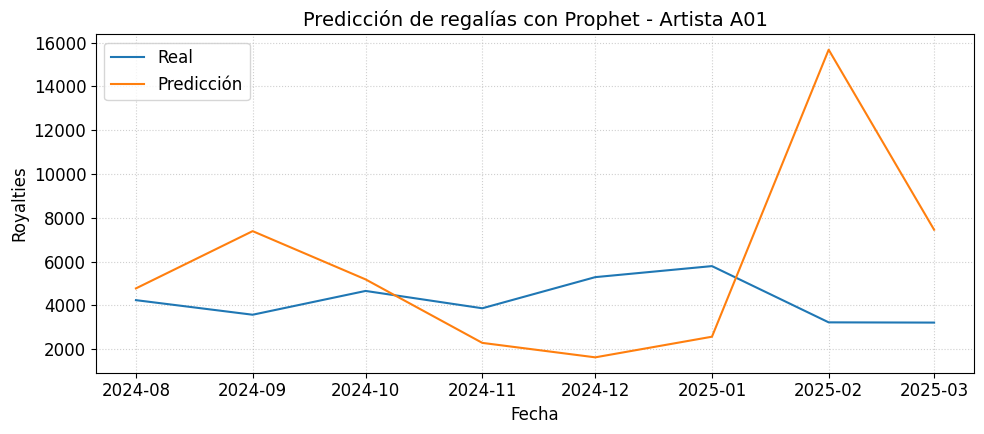

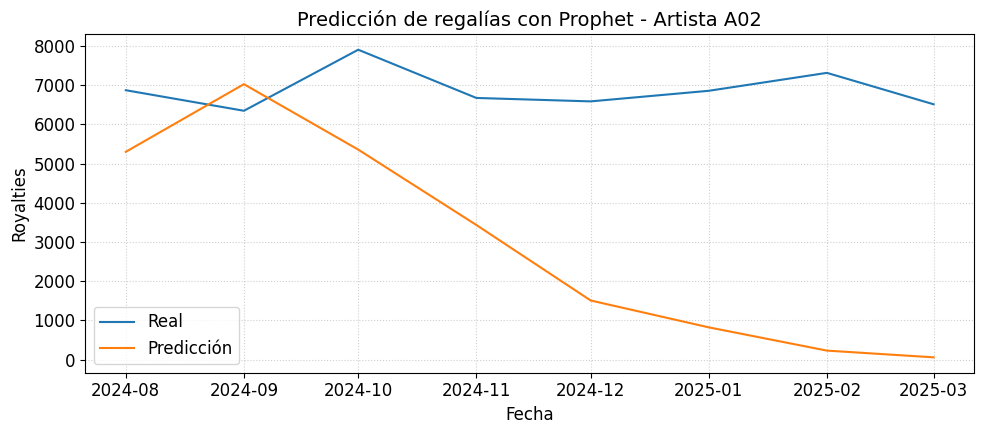

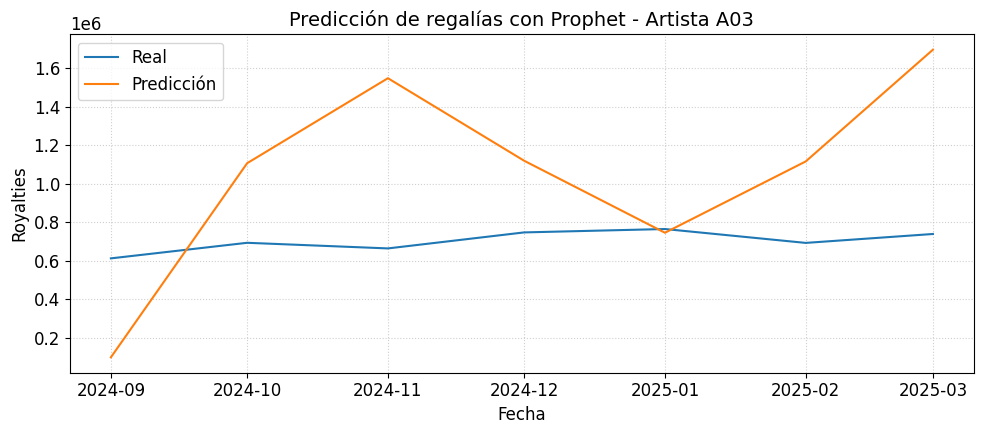

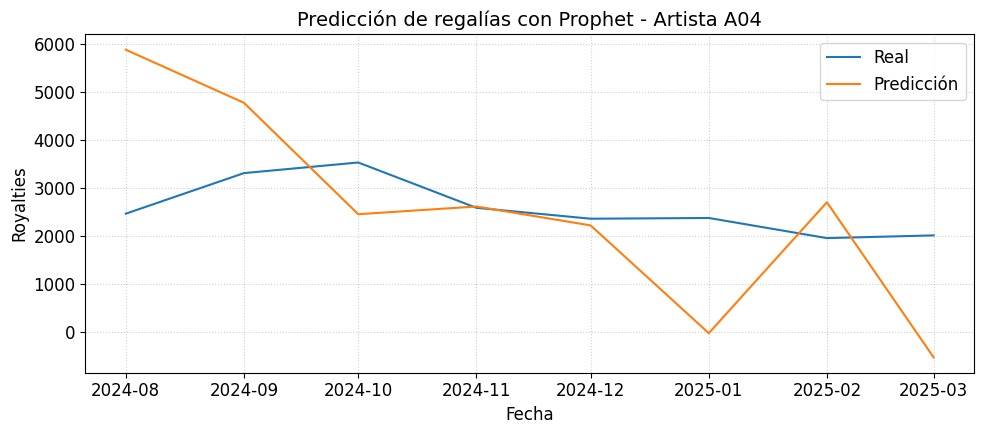

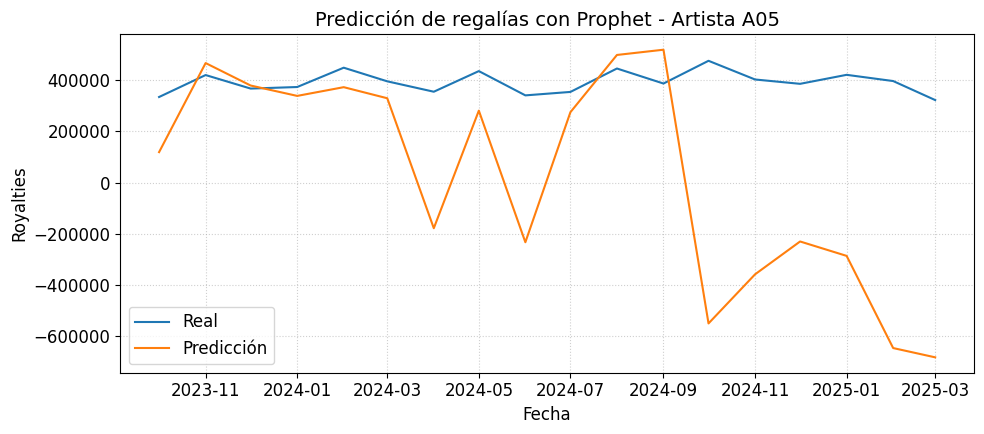

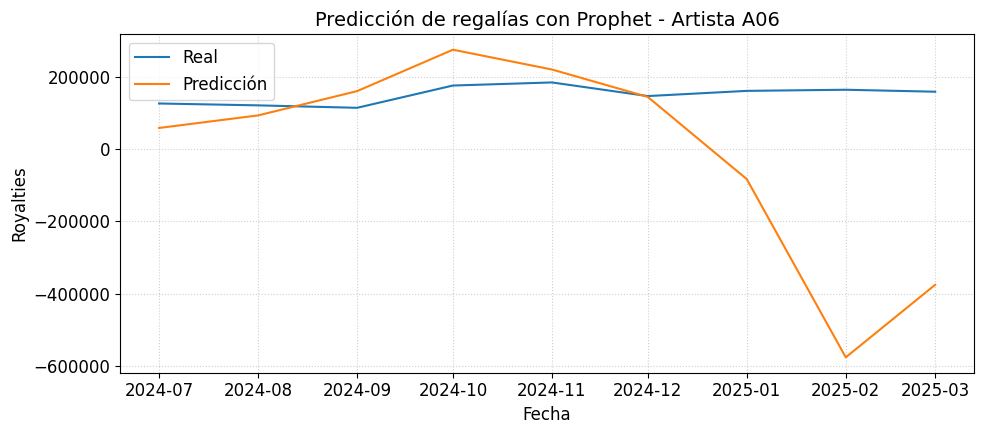

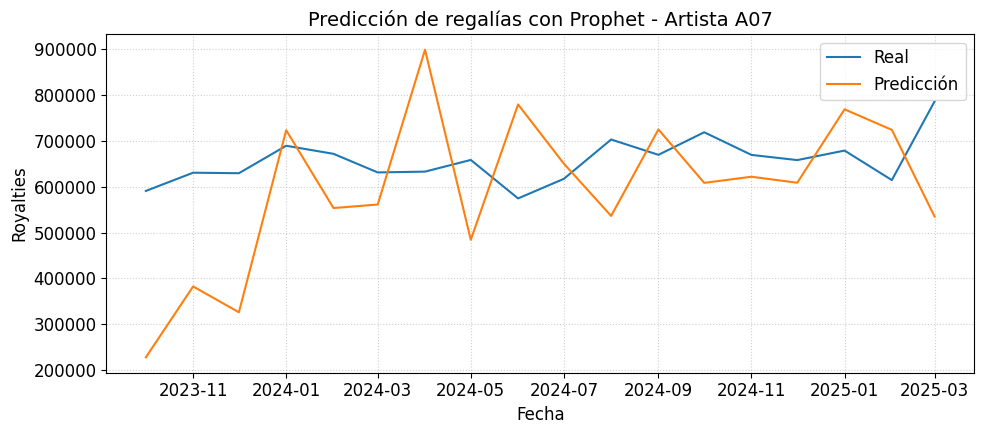

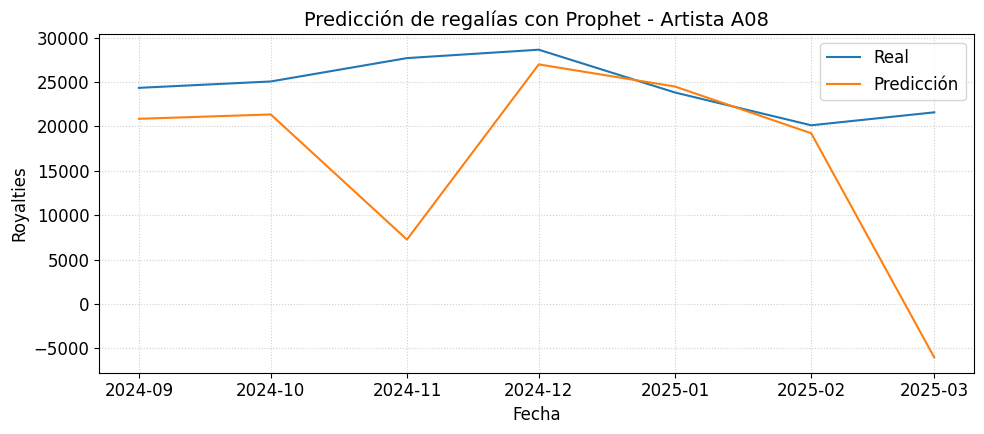

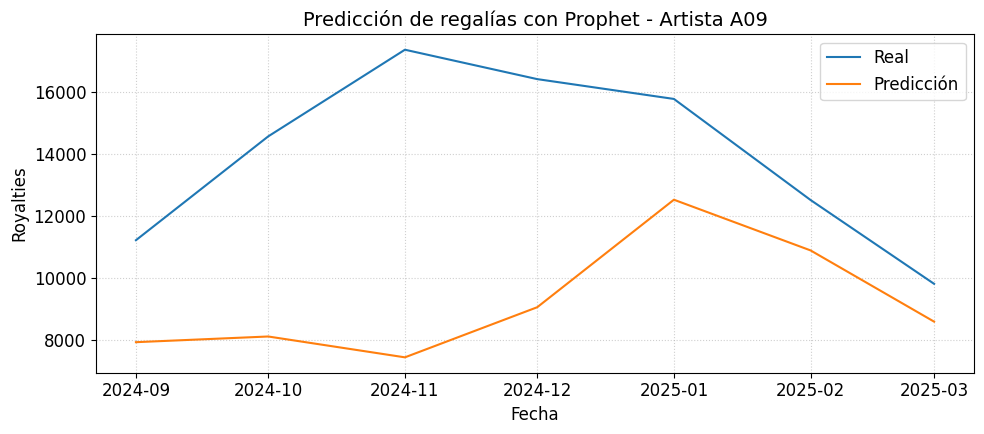

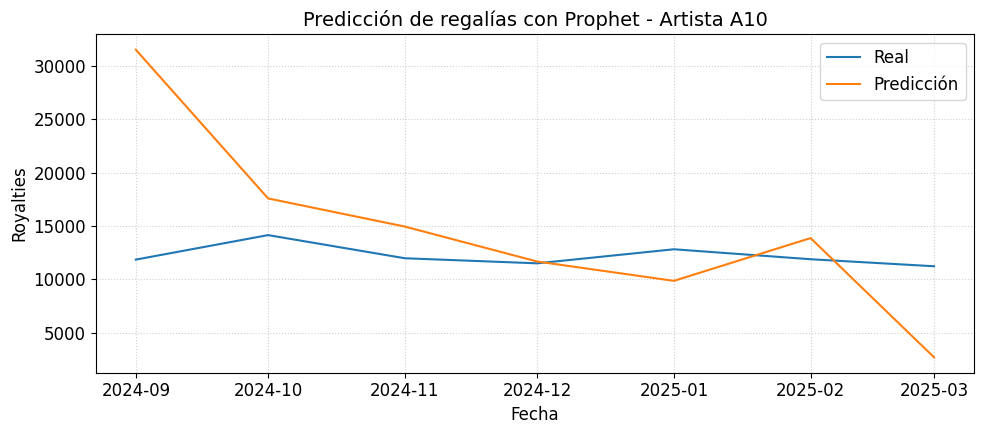

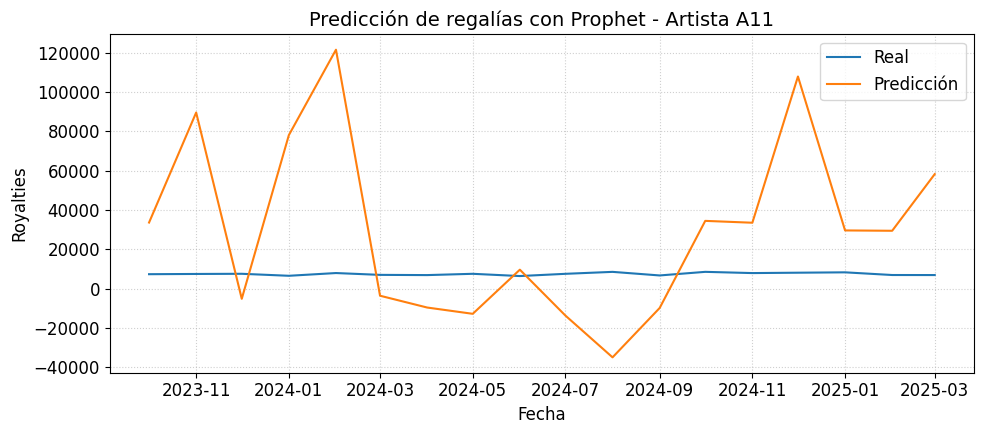

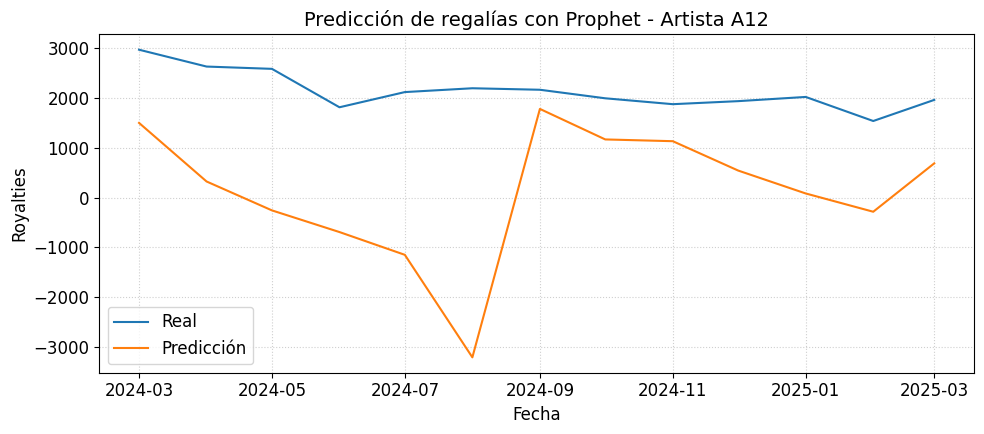

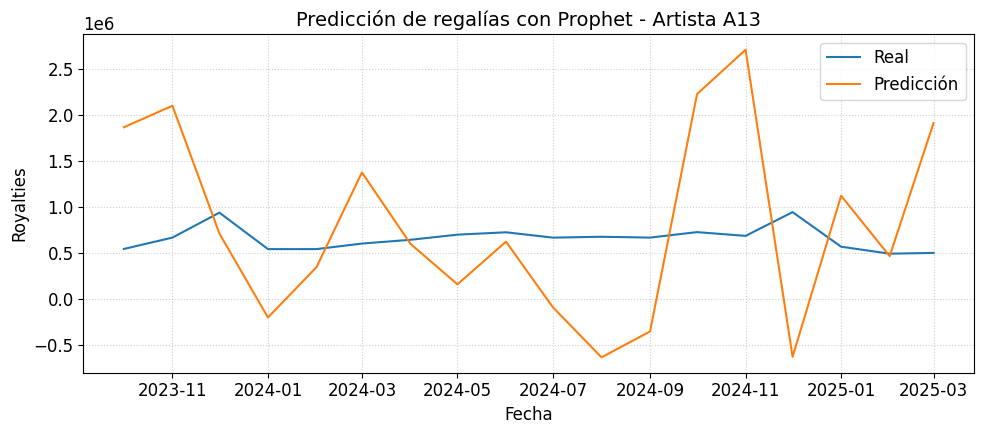

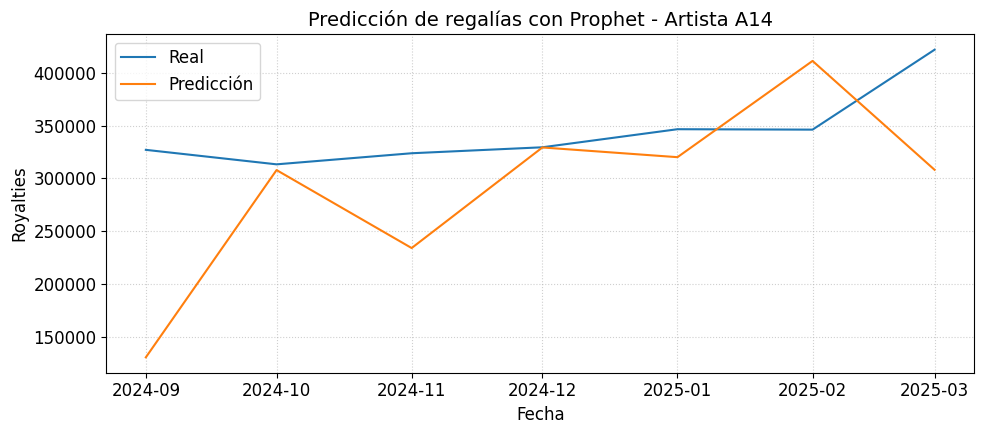

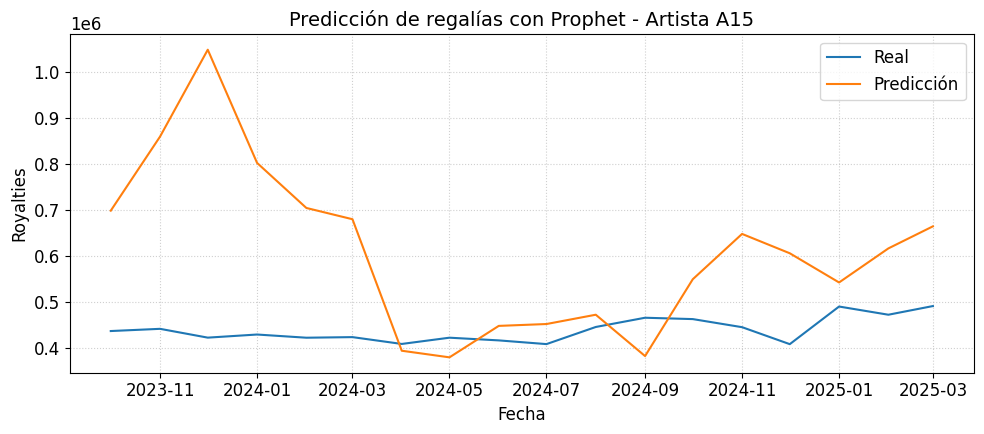

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# Cargar predicciones
df_preds = pd.read_csv("prophet_predicciones_para_powerbi.csv")
df_preds['fecha'] = pd.to_datetime(df_preds['fecha'])

plt.rcParams.update({'font.size': 12})
os.makedirs("figuras_prophet", exist_ok=True)

# 🎨 Colores consistentes
#color_real = "#2E86C1"
#color_pred = "#E67E22"

for artist in df_preds["artist_id"].unique():
    subset = df_preds[df_preds["artist_id"] == artist].copy().sort_values("fecha")

    plt.figure(figsize=(10, 4.5))
    plt.plot(
        subset["fecha"], subset["royalties_real"],
        label="Real")#, color=color_real, linewidth=2)
    plt.plot(
        subset["fecha"], subset["royalties_pred"],
        label="Predicción")#, color=color_pred, linewidth=2, linestyle="--", marker="o", markersize=4)

    plt.title(f"Predicción de regalías con Prophet - Artista {artist}", fontsize=14)
    plt.xlabel("Fecha")
    plt.ylabel("Royalties")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend()

    # 📅 Formato automático de fechas (como en tu imagen)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    #plt.gcf().autofmt_xdate(rotation=30, ha='center')

    plt.tight_layout()
    plt.savefig(f"figuras_prophet/prophet_forecast_{artist}.png", dpi=200)
    plt.show()


In [4]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------
# Cargar mejores hiperparámetros por artista (1 sola vez)
# -----------------------------------------------------------
best_params = pd.read_csv("prophet_best_params_por_artista_expanding.csv") \
    if os.path.exists("prophet_best_params_por_artista_expanding.csv") \
    else pd.read_csv("prophet_best_params_por_artista.csv")

# Regresores disponibles (se toma la intersección con df)
KNOWN_REGS = [
    'instagram_followers','twitter_followers','track_release','sentiment',
    'seguidores_menciones','cant_posteos','cant_comentarios',
    'mean_royalties_6m','std_instagram_followers_6m',
    'growth_twitter_followers','growth_instagram_followers',
    'sum_track_releases_6m','mean_sentiment_3m',
    'sum_seguidores_menciones_3m','month'
]

# -----------------------------------------------------------
# Helpers
# -----------------------------------------------------------
def _safe_growth_rate(s, window=6, clip=0.05):
    """(Se mantiene por si querés usar el modo smooth a futuro)"""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if len(s) <= window or (s.iloc[-window] == 0):
        return 0.01  # +1% por defecto
    g = (s.iloc[-1] / (s.iloc[-window] + 1e-9)) ** (1/window) - 1
    return float(np.clip(g, -clip, clip))

def _build_future_regressors(
    df_artista, steps, regs,
    mode="escenario_forecast",   # <- nombre pedido
    followers_growth=0.01,       # +1% mensual compuesto
    stochastic=False, rng_seed=42,
    sigma_growth=0.02, sigma_level=0.10
):
    """
    Genera X_future según 'mode'.
    - 'escenario_forecast': (estilo LSTM)
        * instagram_followers / twitter_followers: +followers_growth mensual (compuesto)
        * track_release = 0
        * month = mes calendario
        * resto de regresores: HOLD (último valor histórico)
        * sum_track_releases_6m = 0
        * growth_* = followers_growth (constante)
    (Dejo 'stochastic' y parámetros por compatibilidad; para 'escenario_forecast' no se usan.)
    """
    rng = np.random.default_rng(rng_seed)
    g = df_artista.sort_values("fecha").reset_index(drop=True).copy()
    g["fecha"] = pd.to_datetime(g["fecha"]).dt.to_period("M").dt.to_timestamp()
    last_ds = g["fecha"].iloc[-1]
    fechas_fut = pd.date_range(start=last_ds + pd.offsets.MonthBegin(1), periods=steps, freq="MS")
    fut = pd.DataFrame({"ds": fechas_fut})

    last  = g.iloc[-1]
    last6 = g.tail(6)

    # Followers (IG / Twitter)
    if "instagram_followers" in regs:
        v0 = float(last["instagram_followers"])
        fut["instagram_followers"] = [v0 * ((1 + followers_growth) ** i) for i in range(1, steps + 1)]
    if "twitter_followers" in regs:
        v0 = float(last["twitter_followers"])
        fut["twitter_followers"] = [v0 * ((1 + followers_growth) ** i) for i in range(1, steps + 1)]

    # track_release = 0
    if "track_release" in regs:
        fut["track_release"] = 0

    # Engagement / sentiment: HOLD (último valor)
    for c in ["sentiment","seguidores_menciones","cant_posteos","cant_comentarios"]:
        if c in regs:
            fut[c] = float(last[c])

    # Features de ventana: HOLD
    for c in ["mean_royalties_6m","std_instagram_followers_6m","mean_sentiment_3m","sum_seguidores_menciones_3m"]:
        if c in regs:
            fut[c] = float(last[c])

    # sum_track_releases_6m = 0 (consistente con track_release=0)
    if "sum_track_releases_6m" in regs:
        fut["sum_track_releases_6m"] = 0

    # growth_* = followers_growth (constante)
    if "growth_twitter_followers" in regs:
        fut["growth_twitter_followers"] = followers_growth
    if "growth_instagram_followers" in regs:
        fut["growth_instagram_followers"] = followers_growth

    # month desde la fecha futura
    if "month" in regs:
        fut["month"] = fut["ds"].dt.month

    # Asegurar numeric
    for c in regs:
        if c in fut.columns:
            fut[c] = pd.to_numeric(fut[c], errors="coerce").fillna(0)

    return fut

def _bandas_por_residuales(df_resids, artist_id, forecast_df, alpha=0.05):
    """Bandas empíricas por residuales (opcional)."""
    r = df_resids[df_resids["artist_id"] == artist_id].copy()
    r["resid"] = pd.to_numeric(r["royalties_real"], errors="coerce") - pd.to_numeric(r["royalties_pred"], errors="coerce")
    r = r.dropna(subset=["resid"])
    if r.empty:
        out = forecast_df.copy()
        out["lower_ci_emp"] = out["lower_ci"]
        out["upper_ci_emp"] = out["upper_ci"]
        return out
    q_low, q_hi = np.quantile(r["resid"].values, [alpha/2, 1 - alpha/2])
    out = forecast_df.copy()
    out["lower_ci_emp"] = out["royalties_forecast"] + q_low
    out["upper_ci_emp"] = out["royalties_forecast"] + q_hi
    return out

# -----------------------------------------------------------
# Función principal Prophet por artista (usa 'escenario_forecast')
# -----------------------------------------------------------
def forecast_prophet_por_artista(
    df, artist_id, steps=6,
    df_resids=None, alpha=0.05, override_ci_with_empirical=False,
    followers_growth=0.01, use_mcmc=False
):
    """
    Entrena Prophet por artista con sus mejores hiperparámetros y hace forecast +steps
    usando exógenas generadas con 'escenario_forecast'.
    """
    # ---- filtrar y validar ----
    df_artista = df[df['artist_id'] == artist_id].copy().sort_values('fecha')
    if df_artista.empty or df_artista['royalties'].notna().sum() < 2:
        raise ValueError(f'El artista {artist_id} no tiene datos suficientes.')

    # ---- hiperparámetros por artista ----
    rowp = best_params[best_params["Artist_ID"] == artist_id]
    if rowp.empty:
        raise ValueError(f"No hay hiperparámetros para {artist_id}.")

    seasonality_mode        = rowp.iloc[0]['seasonality_mode']
    changepoint_prior_scale = float(rowp.iloc[0]['changepoint_prior_scale'])
    seasonality_prior_scale = float(rowp.iloc[0]['seasonality_prior_scale'])

    # ---- dataset Prophet (mensual) ----
    df_prophet = df_artista.rename(columns={'fecha': 'ds', 'royalties': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.to_period("M").dt.to_timestamp()

    # regresores disponibles en df
    regs = [c for c in KNOWN_REGS if c in df_artista.columns]
    for c in regs:
        df_prophet[c] = pd.to_numeric(df_artista[c], errors="coerce").fillna(0)

    # ---- modelo ----
    modelo = Prophet(
        interval_width=0.95,
        uncertainty_samples=2000,
        mcmc_samples=300 if use_mcmc else 0,
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        changepoint_range=0.85,
        n_changepoints=10,
        yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False
    )
    for reg in regs:
        modelo.add_regressor(reg)

    modelo.fit(df_prophet.set_index('ds').asfreq('MS').reset_index())

    # ---- futuros regresores + predicción completa (histórico + futuro) ----
    future_regs = _build_future_regressors(
        df_artista, steps=steps, regs=regs,
        mode="escenario_forecast",           # <- nombre pedido
        followers_growth=followers_growth,   # +1% mensual por defecto
        stochastic=False                     # sin jitter (HOLD en resto)
    )
    cols_pred = ['ds'] + regs
    pred_input = pd.concat([df_prophet[cols_pred], future_regs[cols_pred]], ignore_index=True)

    forecast_full = modelo.predict(pred_input)

    # ---- armar forecast_df SOLO futuro ----
    last_hist_ds = df_prophet['ds'].max()
    mask_future = forecast_full['ds'] > last_hist_ds
    forecast_future = forecast_full.loc[mask_future, ['ds','yhat','yhat_lower','yhat_upper']].copy()

    forecast_df = pd.DataFrame({
        'artist_id'         : artist_id,
        'fecha_prediccion'  : pd.to_datetime(forecast_future['ds']),
        'royalties_forecast': forecast_future['yhat'].astype(float),
        'lower_ci'          : forecast_future['yhat_lower'].astype(float),
        'upper_ci'          : forecast_future['yhat_upper'].astype(float)
    })

    # ---- bandas empíricas por residuales (opcional) ----
    if df_resids is not None:
        forecast_df = _bandas_por_residuales(df_resids, artist_id, forecast_df, alpha=alpha)
        if override_ci_with_empirical:
            forecast_df['lower_ci'] = forecast_df['lower_ci_emp']
            forecast_df['upper_ci'] = forecast_df['upper_ci_emp']

    # ---- gráfico simple estilo Prophet ----
    fig = modelo.plot(forecast_full)
    ax = fig.gca()
    ax.set_title(f'Forecast Prophet - Artista {artist_id}', fontsize=14, weight='bold')
    ax.set_xlabel('Fecha'); ax.set_ylabel('Royalties')
    fig.tight_layout()
    plt.close(fig)

    return forecast_df, fig

# -----------------------------------------------------------
# Uso: loop por artistas
# -----------------------------------------------------------
lista_artistas  = df['artist_id'].unique()
lista_forecasts = []
lista_figuras   = []

# Si tenés residuales de validación: DataFrame con columnas
# ['artist_id','royalties_real','royalties_pred']
df_resids = None  # reemplazá si lo tenés

for artist_id in lista_artistas:
    try:
        forecast_df, figura = forecast_prophet_por_artista(
            df, artist_id, steps=6,
            df_resids=df_resids, alpha=0.05, override_ci_with_empirical=False,
            followers_growth=0.01,  # +1% mensual (igual que LSTM-style)
            use_mcmc=False
        )
        lista_forecasts.append(forecast_df)
        lista_figuras.append((artist_id, figura))
    except ValueError as e:
        print(f"Salteando artista {artist_id}: {e}")

# Consolidar y guardar
df_forecasts_consolidado = pd.concat(lista_forecasts, ignore_index=True)
df_forecasts_consolidado.to_csv("prophet_forecast_royalties_artistas.csv", index=False)
print("✅ Guardado: prophet_forecast_royalties_artistas.csv")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrrux2jp/alcmzpmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrrux2jp/wpzx9kma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37259', 'data', 'file=/tmp/tmpnrrux2jp/alcmzpmh.json', 'init=/tmp/tmpnrrux2jp/wpzx9kma.json', 'output', 'file=/tmp/tmpnrrux2jp/prophet_model8bwb1npp/prophet_model-20251015202812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrrux2jp/k1wt4s3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnrrux2jp/cjg6qtt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

✅ Guardado: prophet_forecast_royalties_artistas.csv


Forecast +6m — A01


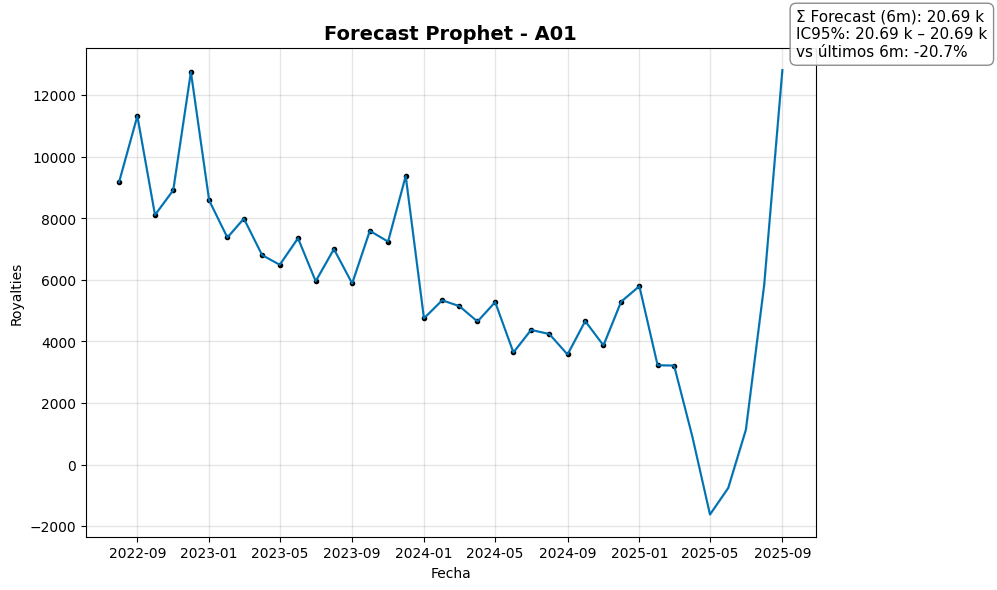

Forecast +6m — A02


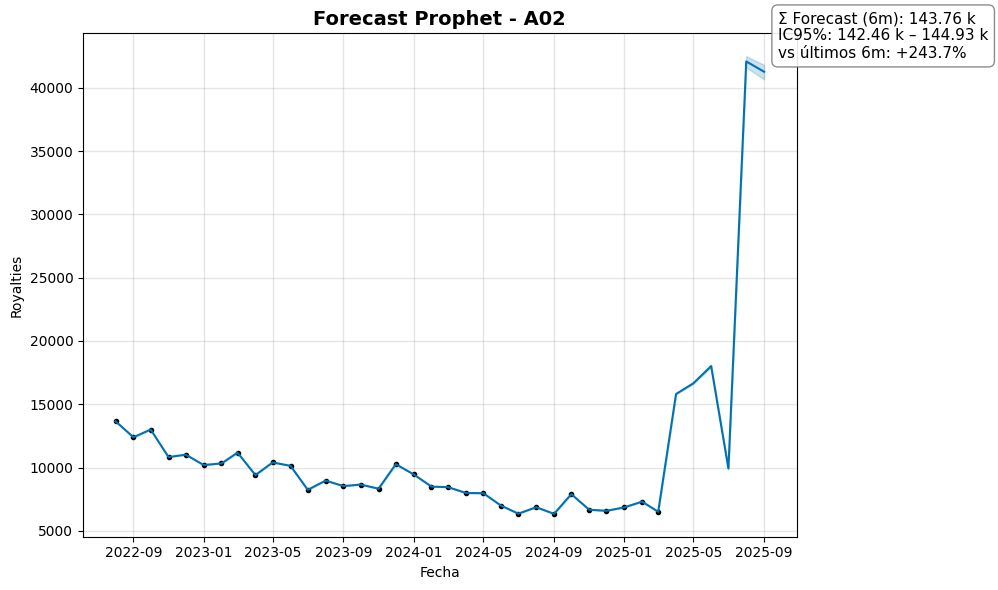

Forecast +6m — A03


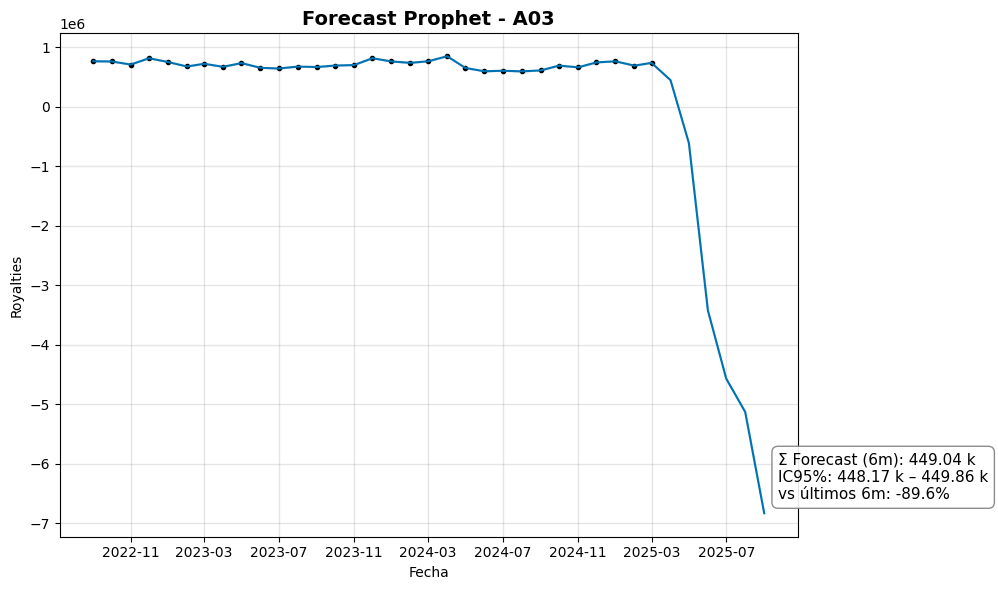

Forecast +6m — A04


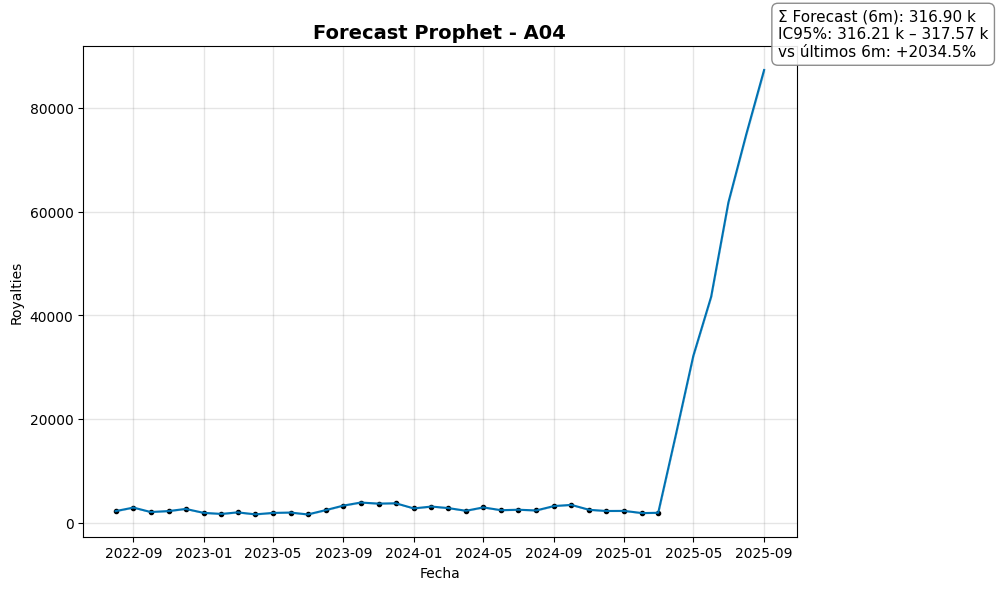

Forecast +6m — A05


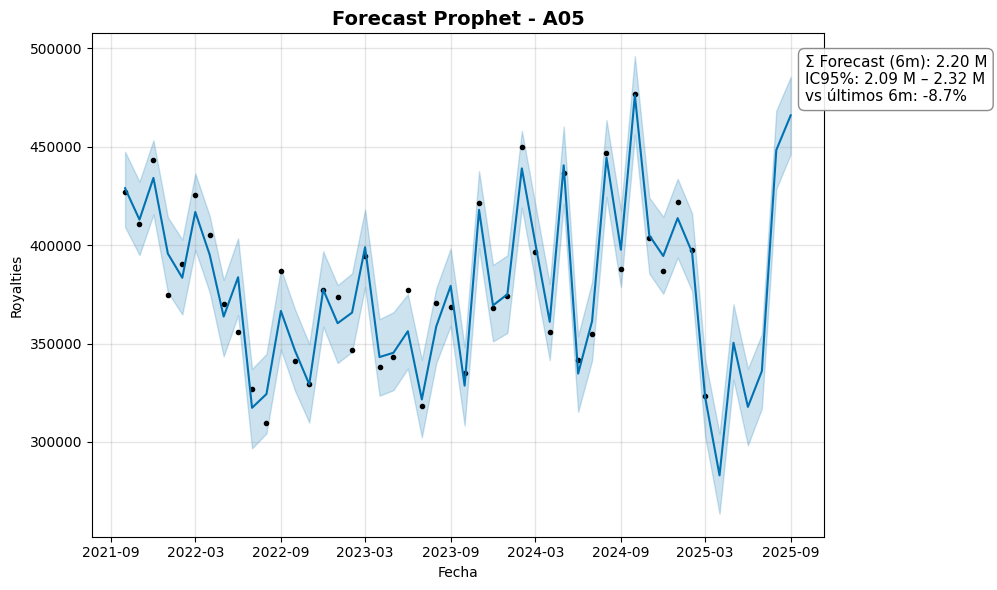

Forecast +6m — A06


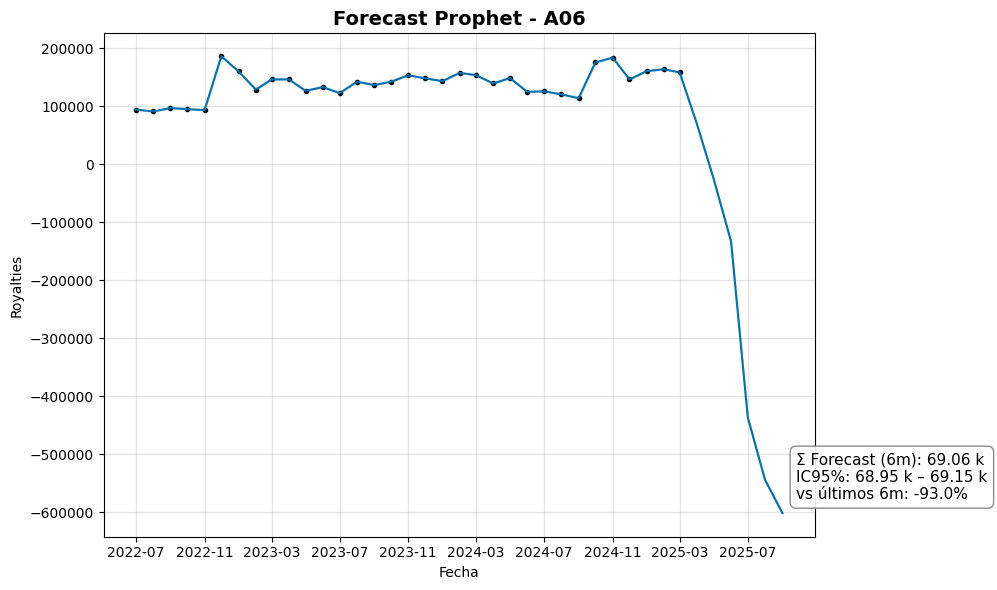

Forecast +6m — A07


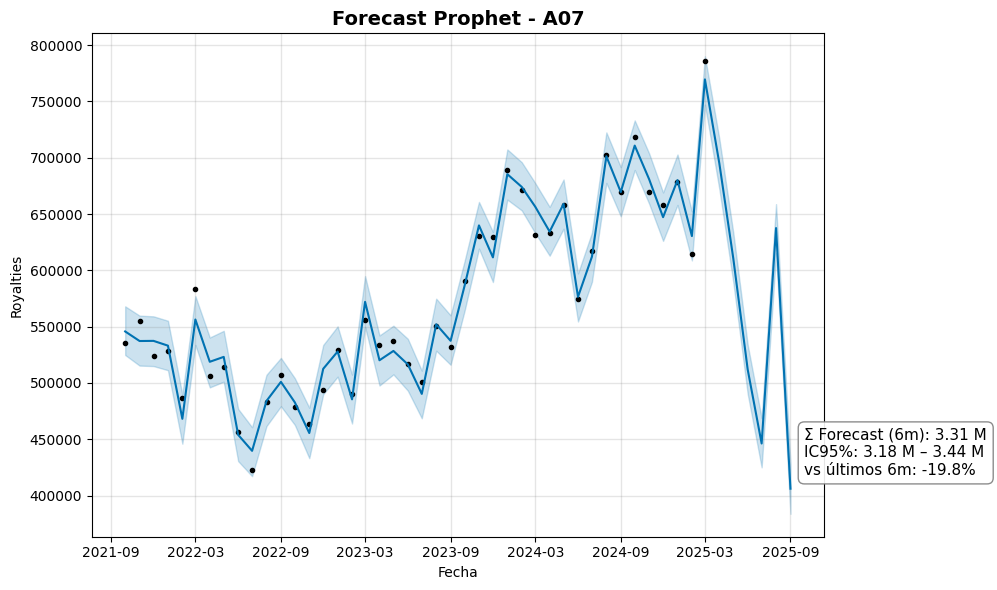

Forecast +6m — A08


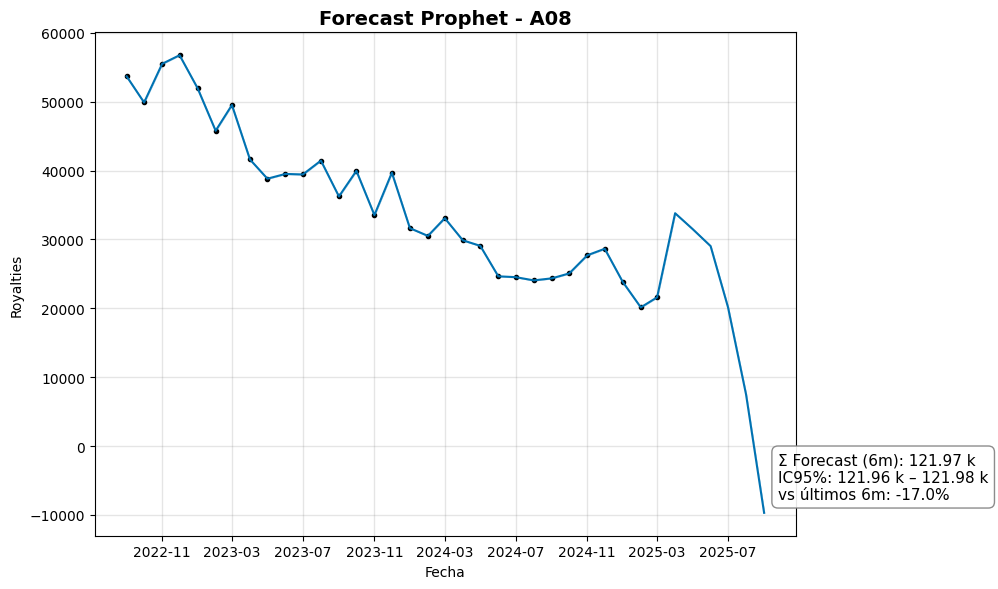

Forecast +6m — A09


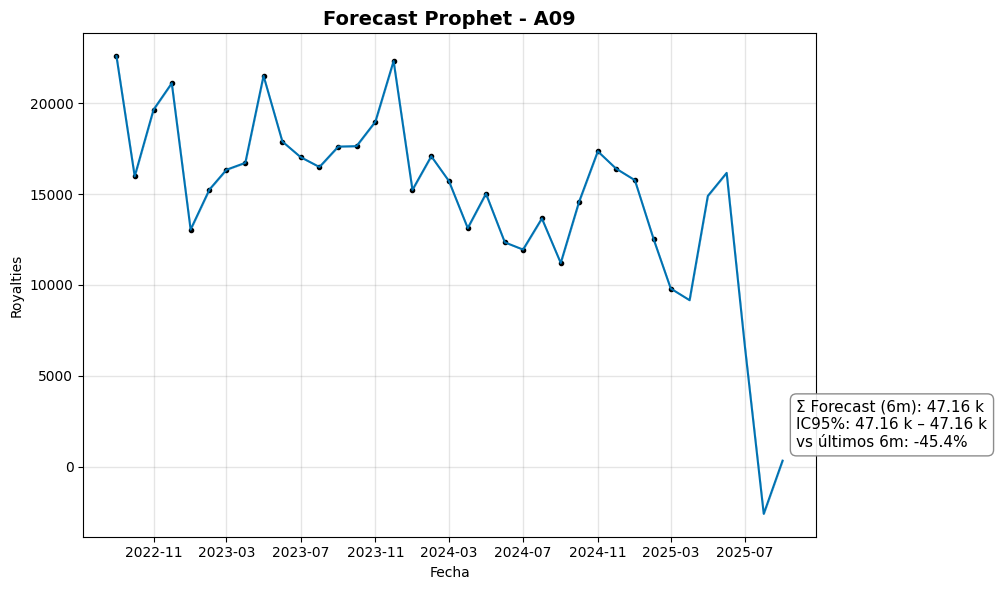

Forecast +6m — A10


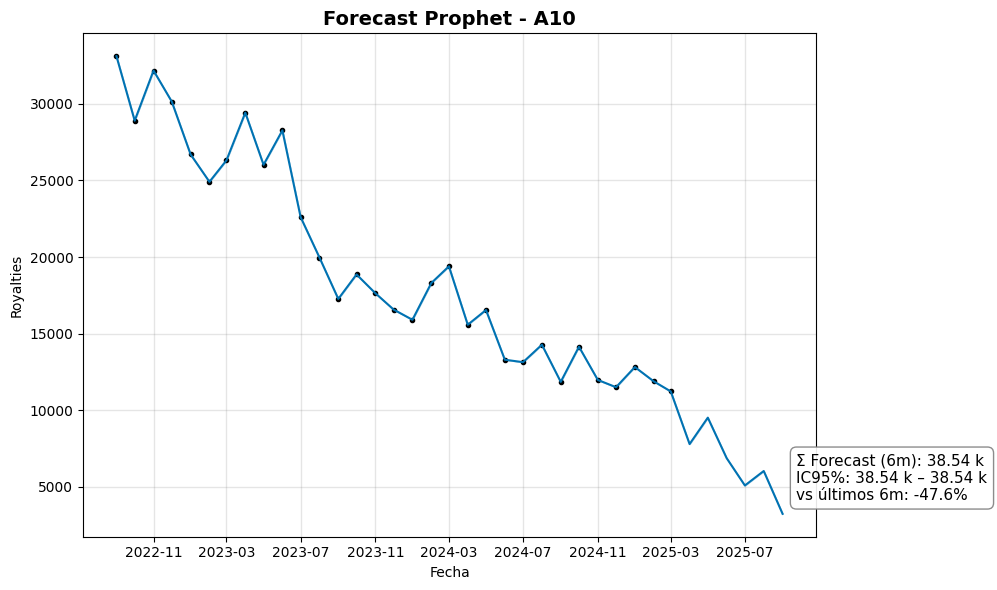

Forecast +6m — A11


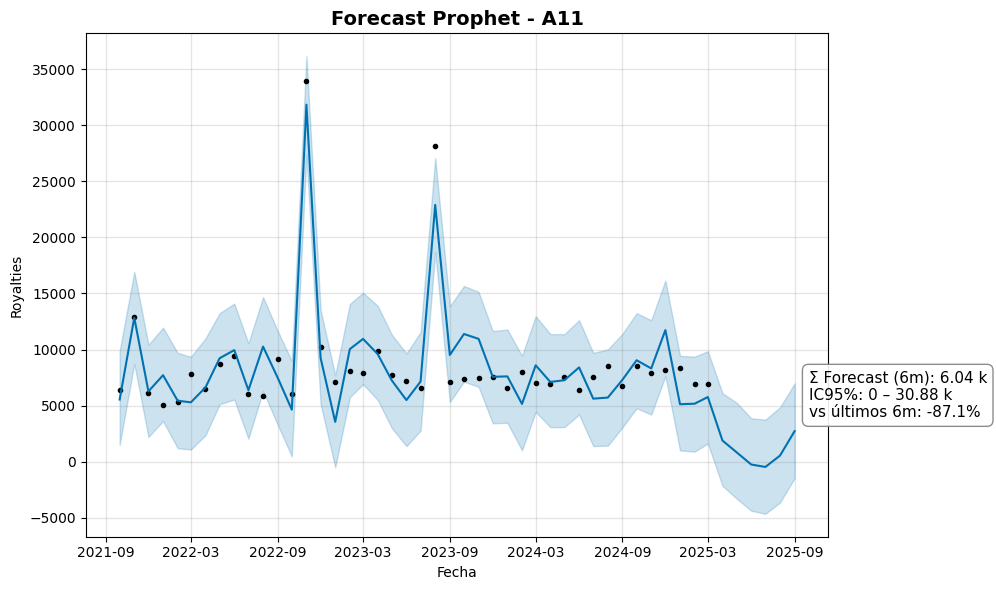

Forecast +6m — A12


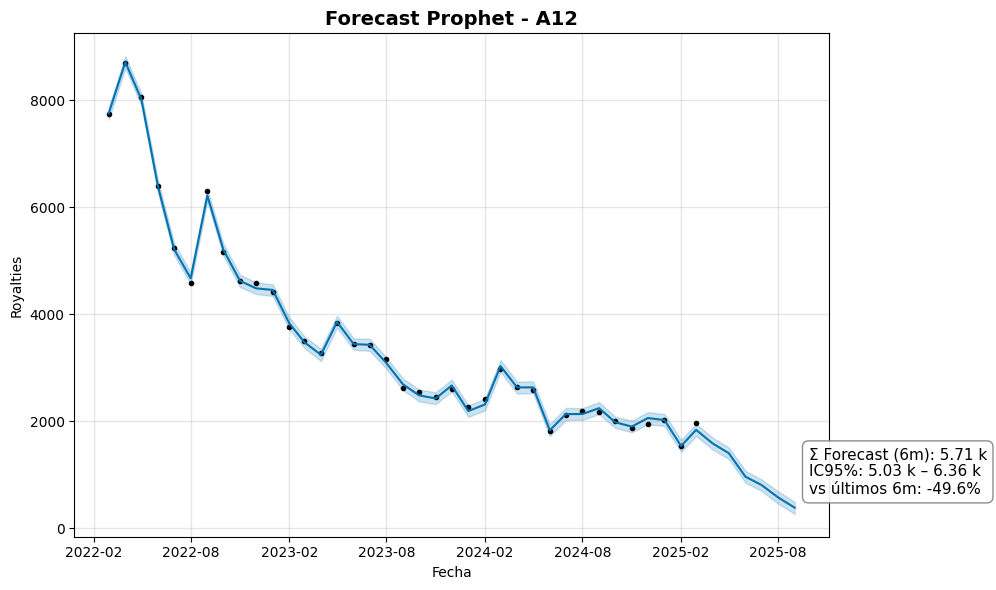

Forecast +6m — A13


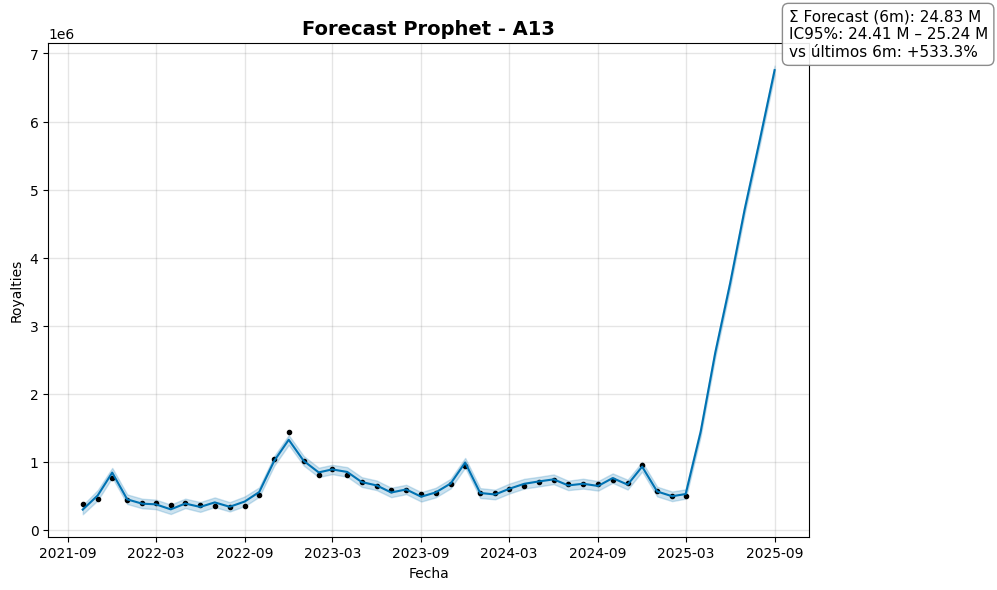

Forecast +6m — A14


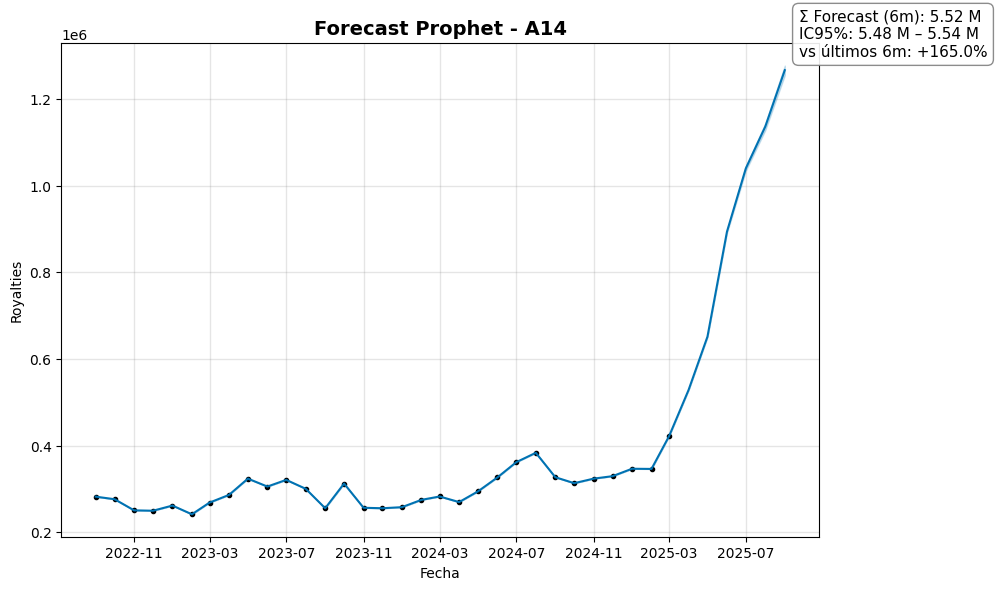

Forecast +6m — A15


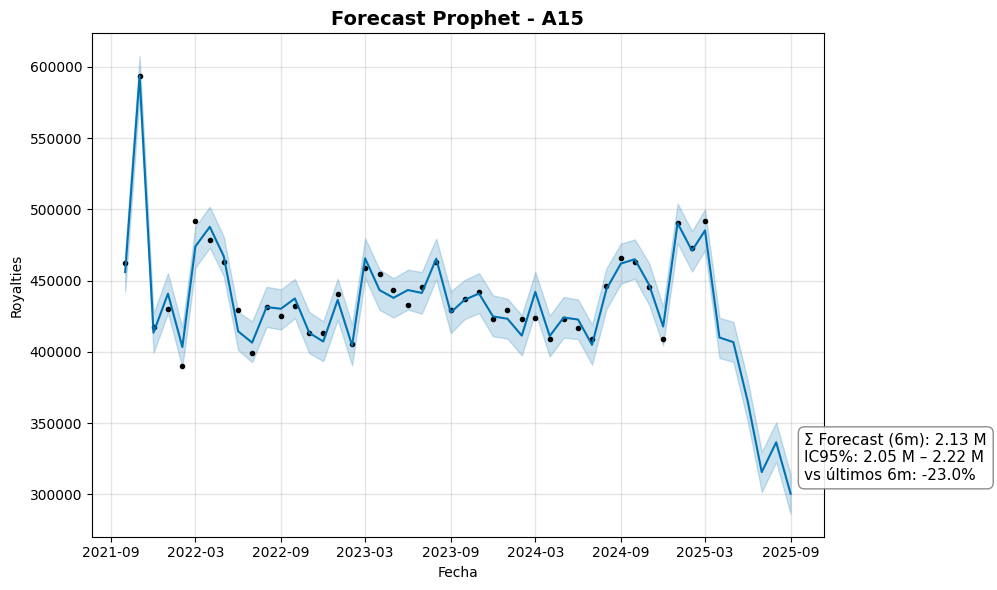

In [5]:
from IPython.display import display
import numpy as np

def _fmt_money(x):
    if x is None or not np.isfinite(x):
        return "—"
    if x >= 1e6:
        return f"{x/1e6:,.2f} M"
    if x >= 1e3:
        return f"{x/1e3:,.2f} k"
    return f"{x:,.0f}"

for (artist_id, fig), forecast_df in zip(lista_figuras, lista_forecasts):
    # ---------- sumatorias forecast ----------
    yhat_col = "royalties_forecast"
    lo_col   = "lower_ci"  if "lower_ci"  in forecast_df.columns else None
    hi_col   = "upper_ci"  if "upper_ci"  in forecast_df.columns else None

    # (opcional) evita negativos en la suma
    yhat_sum = float(np.clip(forecast_df[yhat_col].values, 0, None).sum())
    lo_sum   = float(np.clip(forecast_df[lo_col].values, 0, None).sum()) if lo_col else None
    hi_sum   = float(np.clip(forecast_df[hi_col].values, 0, None).sum()) if hi_col else None

    # ---------- últimos 6 meses históricos ----------
    g_hist = df[df["artist_id"] == artist_id].sort_values("fecha")
    last6_hist_sum = np.nan
    if len(g_hist) >= 6:
        last6_hist_sum = float(g_hist.tail(6)["royalties"].sum())

    pct_vs_last6 = np.nan
    if np.isfinite(last6_hist_sum) and last6_hist_sum > 0:
        pct_vs_last6 = (yhat_sum / last6_hist_sum - 1.0) * 100.0

    # ---------- texto del cartel ----------
    resumen = [
        f"Σ Forecast (6m): {_fmt_money(yhat_sum)}"
    ]
    if lo_col and hi_col:
        resumen.append(f"IC95%: {_fmt_money(lo_sum)} – {_fmt_money(hi_sum)}")
    if np.isfinite(pct_vs_last6):
        signo = "+" if pct_vs_last6 >= 0 else ""
        resumen.append(f"vs últimos 6m: {signo}{pct_vs_last6:.1f}%")
    resumen_txt = "\n".join(resumen)

    # ---------- anotación en la figura ----------
    ax = fig.gca()
    x_last = forecast_df["fecha_prediccion"].iloc[-1]
    y_last = float(forecast_df[yhat_col].iloc[-1])
    y_plot = y_last if np.isfinite(y_last) else ax.get_ylim()[1] * 0.7

    ax.annotate(
        resumen_txt, xy=(x_last, y_plot),
        xytext=(10, 10), textcoords="offset points",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9)
    )

    ax.set_title(f"Forecast Prophet - {artist_id}", fontsize=14, weight="bold")
    fig.tight_layout()

    print(f"Forecast +6m — {artist_id}")
    display(fig)
